### Wasserstein GAN with Gradient Penalty (WGAN-GP)

With a few changes, the authors
were able to show how to train GANs that have the
following two properties (quoted from the paper):
- A meaningful loss metric that correlates with the
generator’s convergence and sample quality
- Improved stability of the optimization process

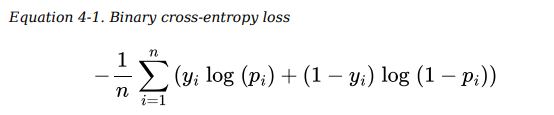

To train the GAN discriminator D, we calculate the loss
when comparing predictions for real images pi = D (xi) to
the response yi = 1 and predictions for generated images
pi = D (G (zi)) to the response yi = 0. Therefore, for the
GAN discriminator, minimizing the loss function can be
written as shown below

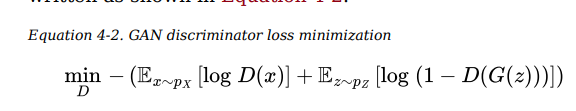

To train the GAN generator G, we calculate the loss when
comparing predictions for generated images pi = D (G (zi))
to the response yi = 1. Therefore, for the GAN generator,
minimizing the loss function can be written as shown below

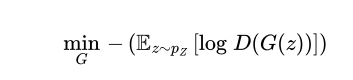

#### WGAN Loss Function
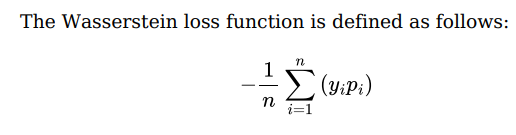

To train the WGAN critic D, we calculate the loss when
comparing predictions for real images pi = D (xi) to the
response yi = 1 and predictions for generated images
pi = D (G (zi)) to the response yi = –1. Therefore, for the
WGAN critic, minimizing the loss function can be written as
follows:

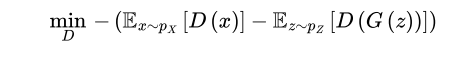

To train the WGAN generator, we calculate the loss when
comparing predictions for generated images pi = D (G (zi))
to the response yi = 1. Therefore, for the WGAN generator,
minimizing the loss function can be written


WGAN paper show that for the
Wasserstein loss function to work, we also need to place an
additional constraint on the critic. Specifically, it is
required that the critic is a 1-Lipschitz continuous function.

The critic is a function D that converts an image into a
prediction. We say that this function is 1-Lipschitz if it
satisfies the following inequality for any two input images,
x1 and x2

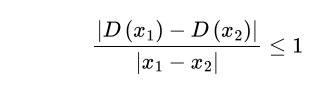

Essentially, we
require a limit on the rate at which the predictions of the
critic can change between two images (i.e., the absolute
value of the gradient must be at most 1 everywhere)

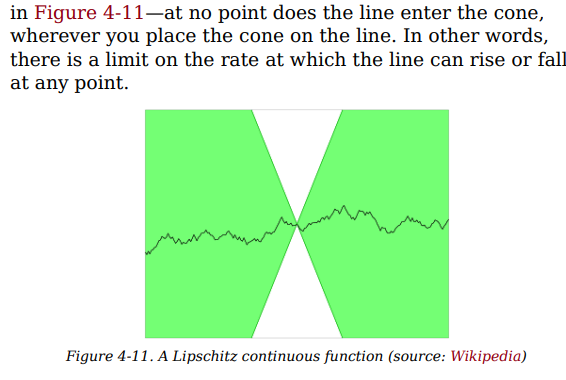



#### Gradient Penalty
The gradient penalty loss measures the squared difference
between the norm of the gradient of the predictions with
respect to the input images and 1. The model will naturally
be inclined to find weights that ensure the gradient penalty
term is minimized, thereby encouraging the model to
conform to the Lipschitz constraint.

In [5]:
from tensorflow.keras import layers, metrics, optimizers, callbacks, losses,models, utils
import numpy as np
import tensorflow as tf
from utils import display, sample_batch

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [7]:
folder = 'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\img_align_celeba\\img_align_celeba'

In [9]:
train_data = utils.image_dataset_from_directory(
 folder,
 labels=None
 ,color_mode='rgb'
 ,image_size=(IMAGE_SIZE,IMAGE_SIZE)
 ,batch_size=BATCH_SIZE
 ,shuffle=True
 ,seed=42
 ,interpolation='bilinear'   
)

def prepocess(img):
    img = (tf.cast(img,'float32') - 127.5)/127.5
    return img

train = train_data.map(lambda x: prepocess(x))    

Found 202599 files belonging to 1 classes.


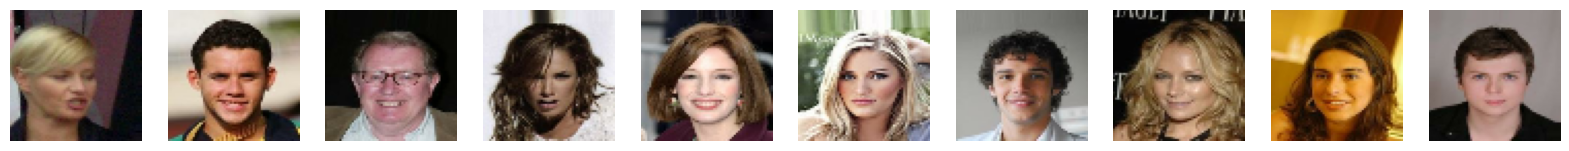

In [11]:
train_sample = sample_batch(train)
display(train_sample,cmap=None)

#### Builing the WGAN GP

In [15]:
critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
x = layers.Conv2D(filters=NUM_FEATURES,kernel_size=4,strides=2,padding='same')(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(filters=NUM_FEATURES*2,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=NUM_FEATURES*4,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=NUM_FEATURES*8,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=1,kernel_size=4,strides=1,padding='valid')(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input,critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [18]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape(target_shape=(1,1,Z_DIM))(generator_input)
x = layers.Conv2DTranspose(filters=512,kernel_size=4,strides=1,padding='valid',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS,kernel_size=4,strides=1,
padding='same',activation='tanh')(x)

generator = models.Model(generator_input,generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 512)        1048576   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 256)        2097

In [20]:
class WGANGP(models.Model):
    def __init__(self,critic,generator,latent_dim,critic_steps,gp_weight):
        super(WGANGP,self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self,c_optimizer, g_optimizer):
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name='wass_loss')
        self.c_gp_metric = metrics.Mean(name='c_gp')
        self.c_loss_metric = metrics.Mean(name='c_loss')
        self.g_loss_metric = metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.wass_loss,
                self.c_gp_metric,
                self.c_loss_metric,
                self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random_normal([batch_size,1,1,1],0.0,1.0)
        diff = real_images - fake_images
        interpolated = diff + alpha * diff
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated,training=True)
        
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        #Ensures gradient is close to 1
        gp = tf.reduce_mean((norm - 1.0)**2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                [batch_size,self.latent_dim]
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors,training=True)
                fake_predictions = self.critic(fake_images,training=True)
                real_predictions = self.critic(real_images,training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp_penalty = self.gradient_penalty(batch_size,real_images,fake_images)
                c_loss = c_wass_loss + c_gp_penalty * self.gp_weight
            
            c_gradient = tape.gradient(c_loss, self.critic.trainaible_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient,self.critic.trainaible_variables))
        
        random_latent_vectors = tf.random.normal(
            [batch_size,self.latent_dim]
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors,training=True)
            fake_predictions = self.critic(fake_images,training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss,self.generator.trainaible_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient,self.generator.trainaible_variables))

        self.c_loss_metric.update_state(c_loss)
        self.c_gp_metric.update_state(c_gp_penalty)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name:m.result() for m in self.metrics()}

In [21]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

NameError: name 'WGANGP' is not defined